# 1.0 SAEON - Identifying marine invertebrates

## Defining the question

### Specifying the Question

The objective of the challenge is to correctly classify images of deep sea invertebrates.. 

Challenge: https://zindi.africa/hackathons/umojahack-1-saeon-identifying-marine-invertebrates/data


### Metric for success
- Log loss

### Understanding the context

The images are of various species of marine invertebrates found off of the coast of South Africa. Further details of the species can be found in the linked field guide.

There are 3111 images in the train set, 1423 images in the test set and 137 different species. The test set has the same class distribution as the training set

### Approach

CRISP- DM methodology will be applied. Below steps will be undertaken to create the classifer.

- Business understanding - understanding the background about deep sea marine invertebrates
- Data understanding - Explore the images
- Exploratory data analysis - check the distribution
- Feature engineering - data augmentation
- Data modelling - Baseline model, Transfer learning and data augmentation
- Model interpretation - Interpret based on model output
- Upload to Zindi

## 2.0 Libraries Importation

In [13]:
#Data Manipulation Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #regular expressions
#Progress bar
from tqdm import tqdm
from datetime import datetime
#Read Images
import os
from skimage import io
#from skimage import io #returning error ImportError: cannot import name 'io' so temporarily commented
from PIL import Image
import cv2 # When open cv was used, there was an error in getting array from image. Using Pillow eliminated the error.

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Image copy
from shutil import copyfile
from random import seed
from random import random
import shutil


#Model Pre-processing
#from sklearn.model_selection import train_test_split

#Modelling
import tensorflow as tf
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  r2_score,roc_auc_score,f1_score,recall_score,precision_score,classification_report, confusion_matrix,log_loss
import random


# Image load
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# Increase rows and columns visible on the notebook
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 100)

# import required libraries
import warnings
warnings.filterwarnings("ignore")

### Explore Images in Directories

Check main directory and inspect subdirectories under it

In [14]:
# Images in training directory
image_path = '../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small'
train_directories = os.listdir(image_path)
print("There are ",len(train_directories), " directories")
print(train_directories)

There are  137  directories
['Cheilostomatida', 'Cypraeovula_iutsui', 'Crossaster_penicillatus', 'Ophiura_trimeni', 'Synallactes_viridilimus', 'Sympagurus_dimorphus', 'Suberites_dandelenae', 'Salpa_spp_', 'Cephalodiscus_gilchristi', 'Miersiograpsus_kingsleyi', 'Philine_aperta', 'Alcyonacea', 'Ceramaster_patagonicus_euryplax', 'Haliporoides_triarthrus', 'Bolocera_kerguelensis', 'Bryozoa', 'Africolaria_rutila', 'Turritella_declivis', 'Marginella_musica', 'Pasiphaea_sp._1', 'Neolithodes_asperrimus', 'Aristeus_varidens', 'Cosmasterias_felipes', 'Exodromidia_spinosissima', 'Hemiocnus_insolens', 'Polychaete_tubes_(only)', 'Diplopteraster_multipes', 'Prawns', 'Holothuroidea', 'Terebratulina_sp_', 'Toraster_tuberculatus', 'Glyphocrangon_spp', 'Solenocera_africana', 'Fusitriton_magellanicus', 'Comitas_stolida', 'Porifera', 'Actiniaria', 'Anthoptilum_grandiflorum', 'Charonia_lampas', 'Lophaster_quadrispinus', 'Pagurus_cuanensis', 'Chrysaora_spp', 'Athleta_abyssicola', 'Mycale_anisochela', 'Aequo

How many images in each of the directories

In [15]:
# How many images in directories
for category in train_directories:
    full_image_path = image_path + "/" +category + "/"
    print(category,len(os.listdir(full_image_path)))
    

Cheilostomatida 12
Cypraeovula_iutsui 17
Crossaster_penicillatus 24
Ophiura_trimeni 12
Synallactes_viridilimus 17
Sympagurus_dimorphus 26
Suberites_dandelenae 60
Salpa_spp_ 19
Cephalodiscus_gilchristi 10
Miersiograpsus_kingsleyi 22
Philine_aperta 12
Alcyonacea 13
Ceramaster_patagonicus_euryplax 12
Haliporoides_triarthrus 18
Bolocera_kerguelensis 28
Bryozoa 17
Africolaria_rutila 10
Turritella_declivis 18
Marginella_musica 30
Pasiphaea_sp._1 11
Neolithodes_asperrimus 13
Aristeus_varidens 28
Cosmasterias_felipes 30
Exodromidia_spinosissima 10
Hemiocnus_insolens 13
Polychaete_tubes_(only) 14
Diplopteraster_multipes 14
Prawns 41
Holothuroidea 13
Terebratulina_sp_ 15
Toraster_tuberculatus 25
Glyphocrangon_spp 19
Solenocera_africana 20
Fusitriton_magellanicus 14
Comitas_stolida 11
Porifera 99
Actiniaria 37
Anthoptilum_grandiflorum 22
Charonia_lampas 13
Lophaster_quadrispinus 27
Pagurus_cuanensis 25
Chrysaora_spp 16
Athleta_abyssicola 31
Mycale_anisochela 10
Aequorea_spp 24
Stylasteridae 31
Ex

Create a dataframe with image paths, image name and image category

In [16]:
image_categories = []
file_names =[]
image_names = []
# Loop across the directories having images.
for category in train_directories:        
    #full_image_path = image_path +  category + "/" +category + "/"
    full_image_path = image_path + "/" +category + "/"
    # Retrieve the filenames from the all the  directories. OS package used.
    image_file_names = [os.path.join(full_image_path, f) for f in os.listdir(full_image_path)] 
    # Read the labels and load them into an array
    for file in image_file_names:
        # Eliminate path from file name
        file_name = os.path.basename(file) 
        image_categories.append(category)
        file_names.append(file)
        image_names.append(file_name)

print("Images count ",len(file_names))
df = pd.DataFrame({'file_names': file_names, 'image_names': image_names,'image_categories':image_categories}, columns=['file_names', 'image_names','image_categories'])
df.sample(5)

Images count  3111


,file_names,image_names,image_categories
159,../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifyi...,FT98XT1.jpeg,Suberites_dandelenae
975,../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifyi...,RNTKQ3W.jpeg,Stylasteridae
2779,../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifyi...,VK8EGDQ.jpeg,Munida_benguela
811,../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifyi...,O4JNLWO.jpeg,Anthoptilum_grandiflorum
1438,../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifyi...,2CKP1EE.jpeg,Philinopsis_capensis


## View Image Sizes and Actual Images

### View Image Properties i.e RBG and image sizes

In [17]:
#Function to upload and if need be resize the training images
def upload_train_images(image_path, categories ,height, width):
    images = []
    labels = []
    file_names =[]
    # Loop across the directories having images.
    for category in categories:
        
        # Append the  category directory into the main path
        full_image_path = image_path + "/" +category + "/"
        # Retrieve the filenames from the all the three wheat directories. OS package used.
        image_file_names = [os.path.join(full_image_path, f) for f in os.listdir(full_image_path)]
            
        # Read the images and load them into an array
        for file in image_file_names[0:100]:         
            image=io.imread(file) #io package from SKimage package
            # Resize?
            #image_from_array = Image.fromarray(image, 'RGB')
            ##Resize image
            #size_image = image_from_array.resize((height, width)) # no resize
            #Append image into list
            images.append(np.array(image))
            # Label for each image as per directory
            labels.append(category)
            file_names.append(file)
        
    return images, labels, file_names

## Invoke the function

#Image resize parameters if needed. Not resizing in this case so code below just a boilerplate incase resizing needed
height = 256
width = 256

train_images, train_categories, train_file_names  = upload_train_images(image_path,train_directories,height,width)
#Size and dimension of output image and labels
train_images = np.array(train_images)
train_categories = np.array(train_categories)
train_file_names = np.array(train_file_names)

#Check properties of uploaded images
print("Shape of training images is " + str(train_images.shape))
print("Shape of training labels is " + str(train_categories.shape))
print("Shape of training labels is " + str(train_file_names.shape))

## Eliminate path from file name
# use regular expressions to extract the name of image
image_names = []
for i in train_file_names:
    fname = os.path.basename(i)
    image_names.append(fname)

#View images
image_names = np.array(image_names)
print(len(image_names))
image_names[0:5]


Shape of training images is (3111,)
Shape of training labels is (3111,)
Shape of training labels is (3111,)
3111


array(['VJE0P74.jpeg', '9F5QRVO.jpeg', 'UTAG0O2.jpeg', '2CRV1OO.jpeg',
       'XVJ8LN5.jpeg'], dtype='<U12')

### Display sample training images

a) Individual images : class, size, labels

Train images, sizes and class labels


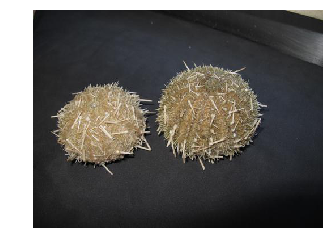

Size of this image is (384, 512, 3)
Class of the image is Polyechinus_agulhensis
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Polyechinus_agulhensis/P9RDSW9.jpeg
Image name is P9RDSW9.jpeg


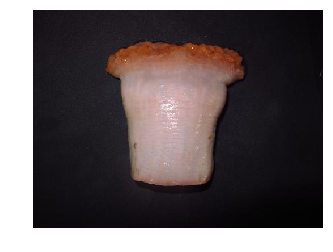

Size of this image is (384, 512, 3)
Class of the image is Actinostola_capensis
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Actinostola_capensis/1SUW3ID.jpeg
Image name is 1SUW3ID.jpeg


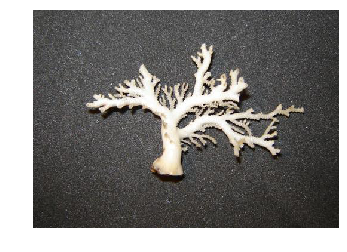

Size of this image is (365, 512, 3)
Class of the image is Stylasteridae
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Stylasteridae/W5X3BMR.jpeg
Image name is W5X3BMR.jpeg


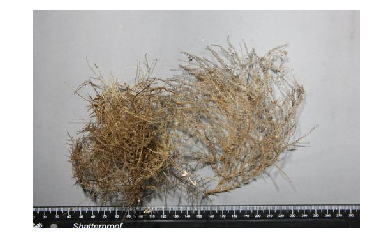

Size of this image is (341, 512, 3)
Class of the image is Hydrozoa_spp
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Hydrozoa_spp/KKUM4JK.jpeg
Image name is KKUM4JK.jpeg


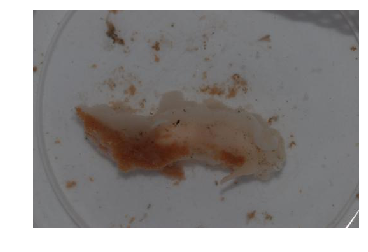

Size of this image is (342, 512, 3)
Class of the image is Nudibranchia
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Nudibranchia/FFIPDUY.jpeg
Image name is FFIPDUY.jpeg


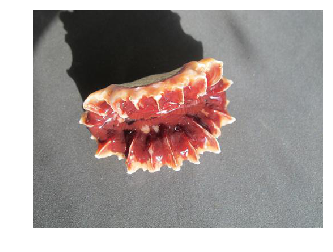

Size of this image is (384, 512, 3)
Class of the image is Flabellum_(Ulocyathus)_messum
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Flabellum_(Ulocyathus)_messum/6COT25Y.jpeg
Image name is 6COT25Y.jpeg


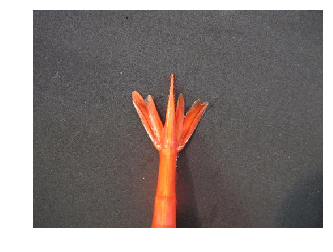

Size of this image is (384, 512, 3)
Class of the image is Prawns
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Prawns/HIYTZA0.jpeg
Image name is HIYTZA0.jpeg


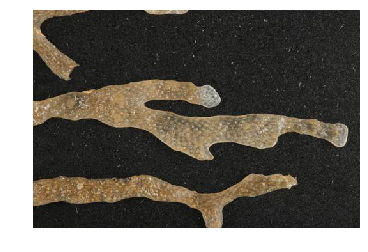

Size of this image is (341, 512, 3)
Class of the image is Cheilostomatida
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Cheilostomatida/VJE0P74.jpeg
Image name is VJE0P74.jpeg


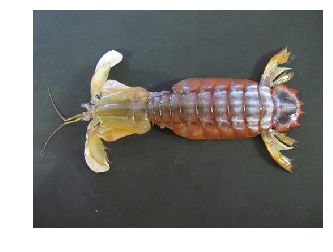

Size of this image is (384, 512, 3)
Class of the image is Pterygosquilla_capensis
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Pterygosquilla_capensis/66TE3ZL.jpeg
Image name is 66TE3ZL.jpeg


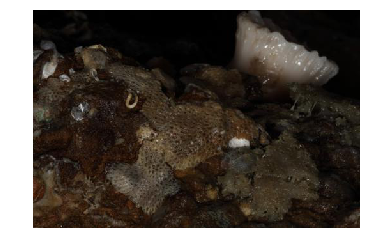

Size of this image is (341, 512, 3)
Class of the image is Scleractinia
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Scleractinia/AB3JNMX.jpeg
Image name is AB3JNMX.jpeg


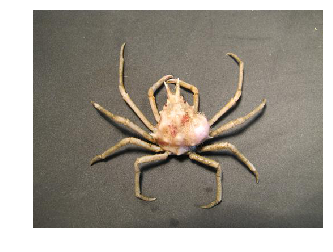

Size of this image is (384, 512, 3)
Class of the image is Rochinia_hertwigi
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Rochinia_hertwigi/CN1KV89.jpeg
Image name is CN1KV89.jpeg


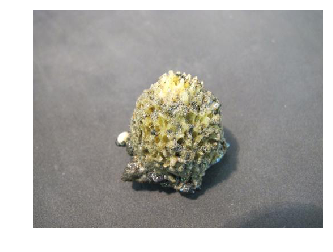

Size of this image is (384, 512, 3)
Class of the image is Porifera
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Porifera/ZOM83AT.jpeg
Image name is ZOM83AT.jpeg


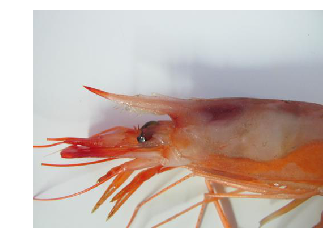

Size of this image is (384, 512, 3)
Class of the image is Aristeus_varidens
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Aristeus_varidens/YUB9AU5.jpeg
Image name is YUB9AU5.jpeg


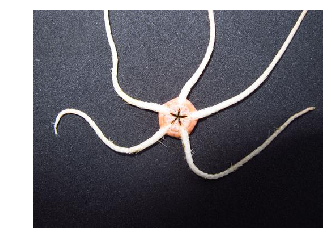

Size of this image is (384, 512, 3)
Class of the image is Ophiura_trimeni
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Ophiura_trimeni/CR24D1U.jpeg
Image name is CR24D1U.jpeg


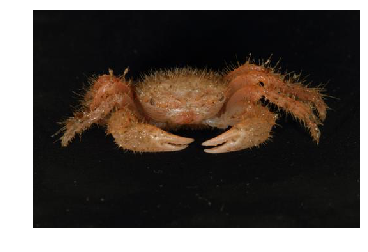

Size of this image is (341, 512, 3)
Class of the image is Miersiograpsus_kingsleyi
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Miersiograpsus_kingsleyi/JIFB69Z.jpeg
Image name is JIFB69Z.jpeg


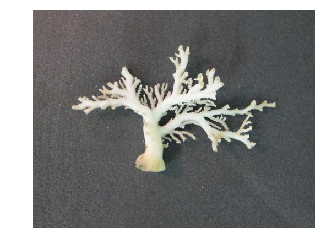

Size of this image is (396, 512, 3)
Class of the image is Stylasteridae
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Stylasteridae/635KF5J.jpeg
Image name is 635KF5J.jpeg


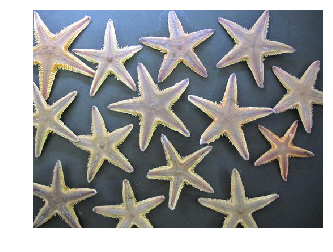

Size of this image is (384, 512, 3)
Class of the image is Astropecten_irregularis_pontoporeus
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Astropecten_irregularis_pontoporeus/B356V27.jpeg
Image name is B356V27.jpeg


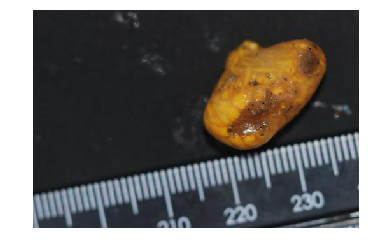

Size of this image is (342, 512, 3)
Class of the image is Ascidiacea
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Ascidiacea/2J3J3H8.jpeg
Image name is 2J3J3H8.jpeg


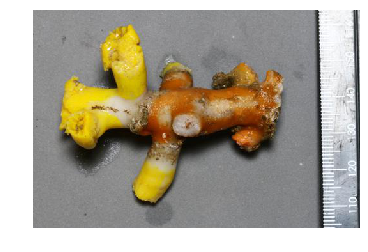

Size of this image is (341, 512, 3)
Class of the image is Scleractinia
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Scleractinia/4VXTBHB.jpeg
Image name is 4VXTBHB.jpeg


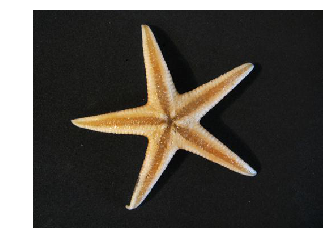

Size of this image is (384, 512, 3)
Class of the image is Psilaster_acuminatus
Image path is ../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/train_small/train_small/Psilaster_acuminatus/V28PYEB.jpeg
Image name is V28PYEB.jpeg


In [18]:
import random
def show_train_images(images, train_categories, train_file_names,image_names,images_count):
     for i in range(images_count):
        
        index = int(random.random() * len(images))
        plt.axis('off')
        plt.imshow(images[index])
        plt.show()
        
        print("Size of this image is " + str(images[index].shape))
        print("Class of the image is " + str(train_categories[index]))
        print("Image path is " + str(train_file_names[index]))        
        print("Image name is " + str(image_names[index]))   

#Execute the function
print("Train images, sizes and class labels")
show_train_images(train_images, train_categories,train_file_names,image_names, 20)

b) Display batch images

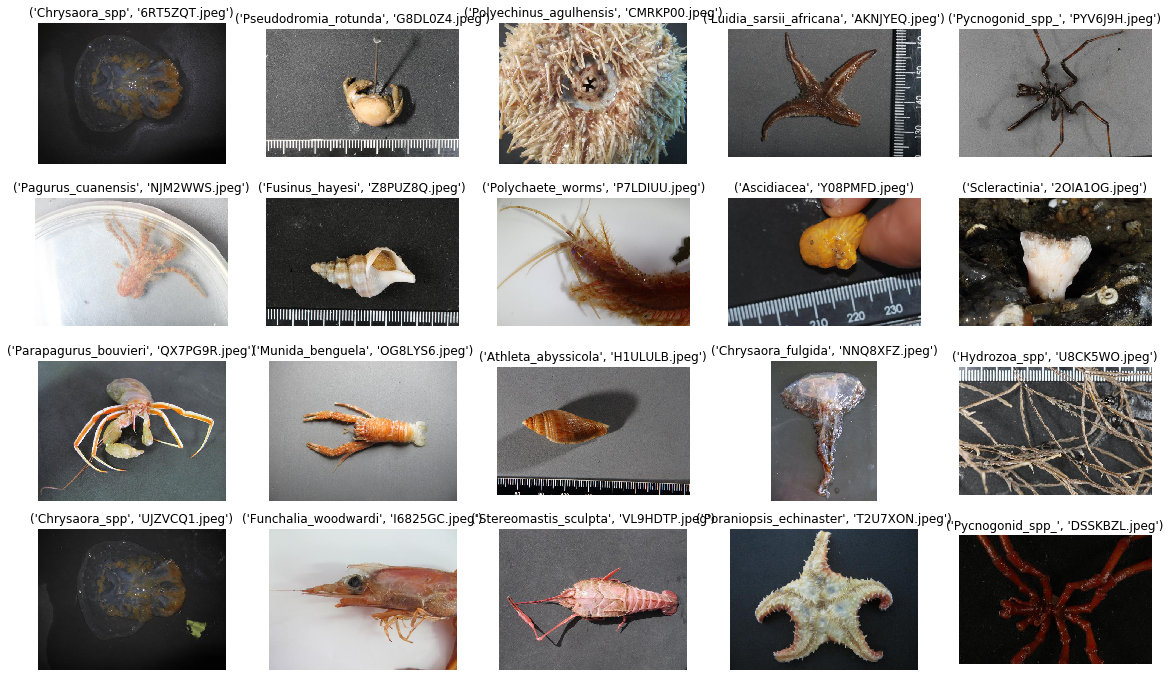

In [19]:
# a function to show the image batch
def show_batch_train_images(images,train_categories,image_names):
    plt.figure(figsize=(20,15))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        index = int(random.random() * len(images))
        plt.imshow(images[index])
        title = train_categories[index],image_names[index]
        plt.title(title)
#         plt.title(CLASS_NAMES[labels[n]==1][0].title())
#         print("Size of this image is " + str(images[index].shape))
        plt.axis('off')

show_batch_train_images(train_images,train_categories,image_names)
plt.show()

### d) Categories of Training Images

Visualize the images distribution per label

In [20]:
#Categories of Images
pd.Series(train_categories).value_counts().reset_index().values.tolist()

[['Porifera', 99],
 ['Inachidae', 88],
 ['Scleractinia', 83],
 ['Polychaete_worms', 80],
 ['Suberites_dandelenae', 60],
 ['Hydrozoa_spp', 51],
 ['Neptuneopsis_gilchristi', 46],
 ['Comitas_saldanhae', 45],
 ['Nassarius_vinctus', 45],
 ['Astropecten_irregularis_pontoporeus', 43],
 ['Pleurobranchaea_bubala', 42],
 ['Rochinia_hertwigi', 41],
 ['Prawns', 41],
 ['Hermit_crab', 40],
 ['Pteraster_capensis', 38],
 ['Poraniopsis_echinaster', 38],
 ['Pycnogonid_spp_', 37],
 ['Ophiura_costata_costata', 37],
 ['Actiniaria', 37],
 ['Isopods', 35],
 ['Seafan', 34],
 ['Perissasterias_polyacantha', 34],
 ['Exodromidia_spinosa', 32],
 ['Brissopsis_lyrifera_capensis', 32],
 ['Henricia_abyssalis', 31],
 ['Stylasteridae', 31],
 ['Athleta_abyssicola', 31],
 ['Lamellaria_Coriocella_spp', 31],
 ['Plesionika_martia', 30],
 ['Cosmasterias_felipes', 30],
 ['Marginella_musica', 30],
 ['Mediaster_bairdi_capensis', 29],
 ['Ophiothrix_fragilis', 29],
 ['Neopilumnoplax_heterochir', 29],
 ['Athleta_lutosa', 28],
 ['Ar

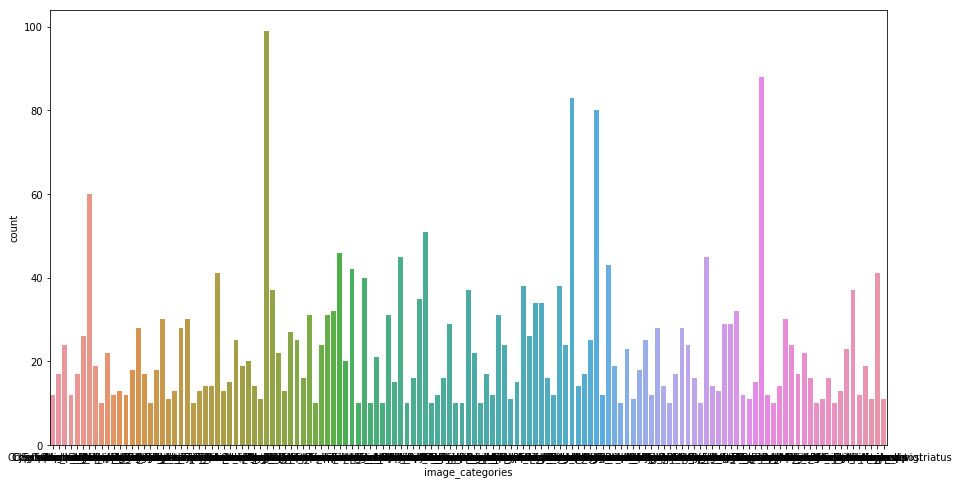

In [21]:
# Plot chart
plt.figure(figsize = (15,8))
sns.countplot(df.image_categories)
plt.show()

### Separate images into Training and Validation
Why? so that i can use Keras data generator

In [22]:
print(random.random())

0.3009397592277069


In [23]:
#Delete working directory if it already exists
def ignore_absent_file(func, path, exc_inf):
    except_instance = exc_inf[1]
    if isinstance(except_instance, FileNotFoundError):
        return
    raise except_instance

shutil.rmtree('/kaggle/working/SAEON', onerror=ignore_absent_file)

# create training and validation directories
dataset_home = 'SAEON/'
subdirs = ['train/', 'validation/']
for subdir in subdirs:
    # create label subdirectories
    for labldir in train_directories:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok=True)
        
#Inspect created directory
#output_path = '/kaggle/working/SAEON/validation'
#os.listdir(output_path)

# Copy files from input to output train and validation directories and their corresponding class directories
import random
seed = 1
val_ratio = 0.25
for index, row in df.iterrows():
    if row['image_categories'] != 'test':
        src = row['file_names']
        if random.random() < val_ratio:
            dst = '/kaggle/working/SAEON/validation'+ '/' + row['image_categories'] + '/' +row['image_names']
        else:
            dst = '/kaggle/working/SAEON/train'+ '/' + row['image_categories'] + '/' +row['image_names']
    copyfile(src, dst)
    
# How many images in directories
# Consider using 
output_path = dst = '/kaggle/working/SAEON/'
print("Validation images")
for category in train_directories[:20]:
    full_image_path = output_path +  'validation' + "/" +category + "/"
    print(category,len(os.listdir(full_image_path)))
print("Training images")
for category in train_directories[:20]:
    full_image_path = output_path +  'train' + "/" +category + "/"
    print(category,len(os.listdir(full_image_path)))

Validation images
Cheilostomatida 4
Cypraeovula_iutsui 6
Crossaster_penicillatus 5
Ophiura_trimeni 5
Synallactes_viridilimus 5
Sympagurus_dimorphus 7
Suberites_dandelenae 13
Salpa_spp_ 7
Cephalodiscus_gilchristi 2
Miersiograpsus_kingsleyi 4
Philine_aperta 5
Alcyonacea 3
Ceramaster_patagonicus_euryplax 4
Haliporoides_triarthrus 9
Bolocera_kerguelensis 7
Bryozoa 4
Africolaria_rutila 4
Turritella_declivis 3
Marginella_musica 7
Pasiphaea_sp._1 1
Training images
Cheilostomatida 8
Cypraeovula_iutsui 11
Crossaster_penicillatus 19
Ophiura_trimeni 7
Synallactes_viridilimus 12
Sympagurus_dimorphus 19
Suberites_dandelenae 47
Salpa_spp_ 12
Cephalodiscus_gilchristi 8
Miersiograpsus_kingsleyi 18
Philine_aperta 7
Alcyonacea 10
Ceramaster_patagonicus_euryplax 8
Haliporoides_triarthrus 9
Bolocera_kerguelensis 21
Bryozoa 13
Africolaria_rutila 6
Turritella_declivis 15
Marginella_musica 23
Pasiphaea_sp._1 10


## Modelling

### Baseline CNN Model. 

3 Layer CNN with 3 by 3 filter and relu activation function.

In [24]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(384, 512, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(137, activation='softmax'))
    # compile model
    
    opt = SGD(lr=0.001, momentum=0.9)
 
    #Compile the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy
    return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()
    
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    print("Define Model")
    model = define_model()
    # create data generator
    print("Creating Image Data Generator")
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    print("Preparing iterators")
    train_it = datagen.flow_from_directory('/kaggle/working/SAEON/train', class_mode='categorical', batch_size=128, target_size=(384, 512)) #binary
    test_it = datagen.flow_from_directory('/kaggle/working/SAEON/validation/', class_mode='categorical', batch_size=128, target_size=(384, 512))
    
    # fit model
    print("Fitting the model")
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    model.save('baseline_marine.h5')
    class_dictionary = train_it.class_indices
    print("Testing the model")
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    return(history,class_dictionary)


#Execute the baseline model
#
model_history,class_dictionary = run_test_harness()


Define Model
Creating Image Data Generator
Preparing iterators
Found 2373 images belonging to 137 classes.
Found 738 images belonging to 137 classes.
Fitting the model
Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 5.0726 - accuracy: 0.0228 - val_loss: 4.9198 - val_accuracy: 0.0285
Epoch 2/20
19/19 [==============================] - 18s 947ms/step - loss: 4.9193 - accuracy: 0.0324 - val_loss: 4.9192 - val_accuracy: 0.0285
Epoch 3/20
19/19 [==============================] - 19s 1s/step - loss: 4.9186 - accuracy: 0.0329 - val_loss: 4.9192 - val_accuracy: 0.0285
Epoch 4/20
19/19 [==============================] - 18s 952ms/step - loss: 4.9178 - accuracy: 0.0320 - val_loss: 4.9179 - val_accuracy: 0.0285
Epoch 5/20
19/19 [==============================] - 19s 975ms/step - loss: 4.9172 - accuracy: 0.0303 - val_loss: 4.9172 - val_accuracy: 0.0257
Epoch 6/20
19/19 [==============================] - 19s 990ms/step - loss: 4.9183 - accuracy: 0.0278 - val_loss: 4.9166 - v

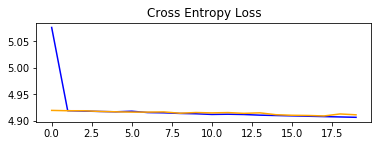

In [29]:
#plot Loss 
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(model_history.history['loss'], color='blue', label='train')
plt.plot(model_history.history['val_loss'], color='orange', label='test')
plt.show()

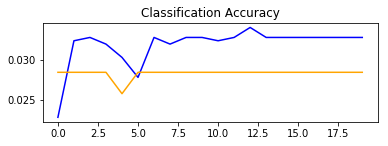

In [31]:
#plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model_history.history['accuracy'], color='blue', label='train')
plt.plot(model_history.history['val_accuracy'], color='orange', label='test')
plt.show()

#### Image Augmentation

In [32]:
# Apply data augmentation on baseline model above.
# Create cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(137, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    #train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    train_it = train_datagen.flow_from_directory('/kaggle/working/SAEON/train/',class_mode='categorical', batch_size=64, target_size=(128, 128))
    test_it = test_datagen.flow_from_directory('/kaggle/working/SAEON/validation/',class_mode='categorical', batch_size=64, target_size=(128, 128))
    
    # fit model
    #history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=5, verbose=1) # Were 10 epochs earlier
    history = model.fit(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1) # Were 10 epochs earlier
    # evaluate model
    #_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    
    model.save('VGGmarine.h5')
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    return(history)


Image Augmentation Results

In [33]:
da_model_history = run_test_harness()

Found 2373 images belonging to 137 classes.
Found 738 images belonging to 137 classes.
Epoch 1/20
38/38 [==============================] - 16s 421ms/step - loss: 4.9115 - accuracy: 0.0190 - val_loss: 4.9743 - val_accuracy: 0.0190
Epoch 2/20
38/38 [==============================] - 16s 422ms/step - loss: 4.8884 - accuracy: 0.0253 - val_loss: 4.8572 - val_accuracy: 0.0244
Epoch 3/20
38/38 [==============================] - 15s 407ms/step - loss: 4.8721 - accuracy: 0.0228 - val_loss: 4.8956 - val_accuracy: 0.0298
Epoch 4/20
38/38 [==============================] - 16s 434ms/step - loss: 4.8632 - accuracy: 0.0464 - val_loss: 4.9261 - val_accuracy: 0.0325
Epoch 5/20
38/38 [==============================] - 16s 413ms/step - loss: 4.8652 - accuracy: 0.0367 - val_loss: 4.8936 - val_accuracy: 0.0176
Epoch 6/20
38/38 [==============================] - 16s 411ms/step - loss: 4.8420 - accuracy: 0.0371 - val_loss: 4.8605 - val_accuracy: 0.0244
Epoch 7/20
38/38 [==============================] - 16s

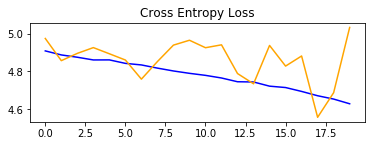

In [34]:
#Plot Cross Entropy Loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(da_model_history.history['loss'], color='blue', label='train')
plt.plot(da_model_history.history['val_loss'], color='orange', label='test')
plt.show()

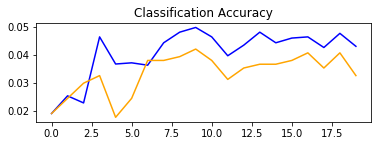

In [35]:
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(da_model_history.history['accuracy'], color='blue', label='train')
plt.plot(da_model_history.history['val_accuracy'], color='orange', label='test')
plt.show()

### Transfer Learning : VGG 16

Transfer learning applied. Image reshaped as per vgg model. Class weights maintained so no upper layers retraining. Switched from SGD to Adam optimizer.

In [36]:
 # Create cnn model
def vgg_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224,224,3)) #weights='imagenet'. Crosscheck before and after 384, 512 weights='imagenet',
    # mark loaded layers as not trainable
    for layer in model.layers:layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(137, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy,
    return model

In [43]:
#Optimization Work Area
 # changed from SGD to ADAM
# model = vgg_model()
# # create data generators
# #train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,vertical_flip = True)
# #train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,vertical_flip = True,horizontal_flip=True,fill_mode='nearest')
# datagen = ImageDataGenerator(featurewise_center=True)
# datagen.mean = [123.68, 116.779, 103.939]
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# # prepare iterators                   
# train_it = train_datagen.flow_from_directory('/kaggle/working/SAEON/train',class_mode='categorical', batch_size=64, target_size=(224,224))
# test_it = test_datagen.flow_from_directory('/kaggle/working/SAEON/validation/',class_mode='categorical', batch_size=64, target_size=(224,224))
# # fit model
# history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=5, verbose=1) #Were 50 epochs earlier
# _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
# print('> %.3f' % (acc * 100.0))

### Train on whole dataset i.e both train and validation. To apply transfer learning and image augmentation model

Create a combined directory with all the train and validation images used earlier for training. We will need to do final training on all images

In [45]:
#Delete directory if it exists.
def ignore_absent_file(func, path, exc_inf):
    except_instance = exc_inf[1]
    if isinstance(except_instance, FileNotFoundError):
        return
    raise except_instance

shutil.rmtree('/kaggle/working/SAEON/combined', onerror=ignore_absent_file)
#Create a directory combining both train and validation dataset
dataset_home = 'SAEON/combined/'
# create label subdirectories
for labldir in train_directories:
    newdir = dataset_home  + labldir
    os.makedirs(newdir, exist_ok=True)
    
# Copy files from input to combined directory. 
for index, row in df.iterrows():
    if row['image_categories'] != 'test':
        src = row['file_names']
        dst = '/kaggle/working/SAEON/combined'+ '/' + row['image_categories'] + '/' +row['image_names']
        copyfile(src, dst)

# How many images in directories
output_path = dst = '/kaggle/working/SAEON/combined'
for category in train_directories[:5]:
    full_image_path = output_path +   "/" +category + "/"
    print(full_image_path)
    print(category,len(os.listdir(full_image_path)))

/kaggle/working/SAEON/combined/Cheilostomatida/
Cheilostomatida 12
/kaggle/working/SAEON/combined/Cypraeovula_iutsui/
Cypraeovula_iutsui 17
/kaggle/working/SAEON/combined/Crossaster_penicillatus/
Crossaster_penicillatus 24
/kaggle/working/SAEON/combined/Ophiura_trimeni/
Ophiura_trimeni 12
/kaggle/working/SAEON/combined/Synallactes_viridilimus/
Synallactes_viridilimus 17


Run Final Model

In [53]:
model = vgg_model()
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
#datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,vertical_flip = True,horizontal_flip=True,fill_mode='nearest')
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train_it = datagen.flow_from_directory('/kaggle/working/SAEON/combined/',class_mode='categorical', batch_size=32, target_size=(224, 224))
print("Fitting the model")
# fit model
model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=100, verbose=1) #Were 11 epochs
    

Found 3111 images belonging to 137 classes.
Fitting the model
Epoch 1/100
98/98 [==============================] - 16s 162ms/step - loss: 6.0785 - accuracy: 0.0691
Epoch 2/100
98/98 [==============================] - 15s 156ms/step - loss: 4.1439 - accuracy: 0.1681
Epoch 3/100
98/98 [==============================] - 16s 165ms/step - loss: 3.7056 - accuracy: 0.2279
Epoch 4/100
98/98 [==============================] - 15s 158ms/step - loss: 3.4229 - accuracy: 0.2678
Epoch 5/100
98/98 [==============================] - 15s 156ms/step - loss: 3.1477 - accuracy: 0.3147
Epoch 6/100
98/98 [==============================] - 15s 158ms/step - loss: 3.0127 - accuracy: 0.3446
Epoch 7/100
98/98 [==============================] - 16s 167ms/step - loss: 2.8186 - accuracy: 0.3655
Epoch 8/100
98/98 [==============================] - 16s 158ms/step - loss: 2.7138 - accuracy: 0.3889
Epoch 9/100
98/98 [==============================] - 15s 157ms/step - loss: 2.6030 - accuracy: 0.4024
Epoch 10/100
98/98 [

98/98 [==============================] - 16s 165ms/step - loss: 1.5462 - accuracy: 0.6345
Epoch 81/100
98/98 [==============================] - 15s 156ms/step - loss: 1.4606 - accuracy: 0.6381
Epoch 82/100
98/98 [==============================] - 15s 157ms/step - loss: 1.4447 - accuracy: 0.6381
Epoch 83/100
98/98 [==============================] - 15s 156ms/step - loss: 1.4384 - accuracy: 0.6416
Epoch 84/100
98/98 [==============================] - 16s 163ms/step - loss: 1.4495 - accuracy: 0.6387
Epoch 85/100
98/98 [==============================] - 16s 159ms/step - loss: 1.4646 - accuracy: 0.6294
Epoch 86/100
98/98 [==============================] - 16s 159ms/step - loss: 1.5541 - accuracy: 0.6278
Epoch 87/100
98/98 [==============================] - 16s 163ms/step - loss: 1.5825 - accuracy: 0.6255
Epoch 88/100
98/98 [==============================] - 16s 160ms/step - loss: 1.5722 - accuracy: 0.6307
Epoch 89/100
98/98 [==============================] - 16s 159ms/step - loss: 1.5521 - 

## Subject the Model to Test Data

Import Test Data

In [60]:
# image_path = '../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/test_small/test_small'
# train_directories = os.listdir(image_path)

#Import test data from test path
t_file_names =[]
t_file_path =[]
test_image_path = '../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/test_small/test_small'
test_image_file_names = [os.path.join(test_image_path, f) for f in os.listdir(test_image_path)] # Retrieve the filenames from the all the  directories. OS package used.
for tfile in test_image_file_names:         # Read the labels and load them into an array
        FILE = os.path.basename(tfile) ## Eliminate path from file name
        t_file_names.append(FILE)    
        t_file_path.append(tfile)

#Create Test Dataframe
df_test = pd.DataFrame({'t_file_names': t_file_names,'t_file_path':t_file_path}, columns=['t_file_names','t_file_path'])

# load the image
test_images =[]
for index, row in df_test.iterrows():
    img = load_img(row['t_file_path'], target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    test_images.append(np.array(img))

Prediction

In [61]:
predictions =[]
for i in test_images:
    y_predict = model.predict(i,batch_size=8,verbose=0)
    predictions.append(y_predict)


In [62]:
def test_images():
    # load the image
    test_images =[]
    for index, row in df_test.iterrows():
        test_images.append(row['t_file_names'])
    return(test_images)

#Execute function
test_images = test_images()

Map labels to prediction and Create Dataframe from predictions and Columns above

In [63]:
column_names = []
labels = (train_it.class_indices)
dict_labels = dict((v,k) for k,v in labels.items())
for key, value in dict_labels.items():
    print(key, '->', value)
    column_names.append(value)
column_names.insert( 0, 'FILE');
column_names

df_FILE = pd.DataFrame(test_images)
df_FILE
print("predicted")
df_predicted = pd.DataFrame(np.concatenate(predictions))
df_predicted[:10]
print("submission")
submission = pd.concat([df_FILE, df_predicted], axis=1)
print("columns")
submission.columns =[column_names]
submission[:5]


0 -> Actiniaria
1 -> Actinoptilum_molle
2 -> Actinoscyphia_plebeia
3 -> Actinostola_capensis
4 -> Aequorea_spp
5 -> Africolaria_rutila
6 -> Alcyonacea
7 -> Amalda_bullioides
8 -> Anthoptilum_grandiflorum
9 -> Aphelodoris_sp_
10 -> Aphrodita_alta
11 -> Aristeus_varidens
12 -> Armina_sp_
13 -> Ascidiacea
14 -> Astropecten_irregularis_pontoporeus
15 -> Athleta_abyssicola
16 -> Athleta_lutosa
17 -> Bolocera_kerguelensis
18 -> Brissopsis_lyrifera_capensis
19 -> Bryozoa
20 -> Cavernularia_spp
21 -> Cephalodiscus_gilchristi
22 -> Ceramaster_patagonicus_euryplax
23 -> Charonia_lampas
24 -> Cheilostomatida
25 -> Cheiraster_hirsutus
26 -> Chondraster_elattosis
27 -> Chrysaora_fulgida
28 -> Chrysaora_spp
29 -> Comanthus_wahlbergii
30 -> Comitas_saldanhae
31 -> Comitas_stolida
32 -> Cosmasterias_felipes
33 -> Crossaster_penicillatus
34 -> Cypraeovula_iutsui
35 -> Diplopteraster_multipes
36 -> Dipsacaster_sladeni_capensis
37 -> Echinus_gilchristi
38 -> Eleutherobia_variable
39 -> Euspira_napus
40 -

,FILE,Actiniaria,Actinoptilum_molle,Actinoscyphia_plebeia,Actinostola_capensis,Aequorea_spp,Africolaria_rutila,Alcyonacea,Amalda_bullioides,Anthoptilum_grandiflorum,Aphelodoris_sp_,Aphrodita_alta,Aristeus_varidens,Armina_sp_,Ascidiacea,Astropecten_irregularis_pontoporeus,Athleta_abyssicola,Athleta_lutosa,Bolocera_kerguelensis,Brissopsis_lyrifera_capensis,Bryozoa,Cavernularia_spp,Cephalodiscus_gilchristi,Ceramaster_patagonicus_euryplax,Charonia_lampas,Cheilostomatida,Cheiraster_hirsutus,Chondraster_elattosis,Chrysaora_fulgida,Chrysaora_spp,Comanthus_wahlbergii,Comitas_saldanhae,Comitas_stolida,Cosmasterias_felipes,Crossaster_penicillatus,Cypraeovula_iutsui,Diplopteraster_multipes,Dipsacaster_sladeni_capensis,Echinus_gilchristi,Eleutherobia_variable,Euspira_napus,Exodromidia_spinosa,Exodromidia_spinosissima,Flabellum_(Ulocyathus)_messum,Funchalia_woodwardi,Fusinus_africanae,Fusinus_hayesi,Fusitriton_magellanicus,Fusivoluta_pyrrhostoma,Glyphocrangon_spp,Goneplax_clevai,Granulifusus_rubrolineatus,Gynandrocarpa_placenta,Halcurias_capensis,Haliporoides_triarthrus,Hemiocnus_insolens,Henricia_abyssalis,Hermit_crab,Hippasteria_phrygiana,Holothuroidea,Hydrozoa_spp,Inachidae,Isididae,Isopods,Kaloplocamus_ramosus,Lamellaria_Coriocella_spp,Limopsis_chuni,Lithodes_ferox,Lophaster_quadrispinus,Luidia_sarsii_africana,Marginella_musica,Marthasterias_africana,Mediaster_bairdi_capensis,Merhippolyte_agulhasensis,Miersiograpsus_kingsleyi,Munida_benguela,Mursia_cristiata,Mycale_anisochela,Nassarius speciosus,Nassarius_vinctus,Neolithodes_asperrimus,Neopilumnoplax_heterochir,Neptuneopsis_gilchristi,Nudibranchia,Ophiomyxa_vivipara_capensis,Ophiothrix_aristulata,Ophiothrix_fragilis,Ophiothrix_spp,Ophiura_costata_costata,Ophiura_trimeni,Pagurus_cuanensis,Parapagurus_bouvieri,Pasiphaea_sp._1,Pasiphaea_sp._2,Pecten_sulcicostatus,Pelagia_noctiluca,Perissasterias_polyacantha,Philine_aperta,Philinopsis_capensis,Phormosoma_placenta_africana,Plesionika_martia,Pleurobranchaea_bubala,Polychaete_tubes_(only),Polychaete_worms,Polyechinus_agulhensis,Poraniopsis_echinaster,Porifera,Prawns,Projasus_parkeri,Pseudarchaster_brachyactis,Pseudarchaster_tessellatus,Pseudodromia_rotunda,Pseudodromia_spp_,Pseudostichopus_langeae,Psilaster_acuminatus,Pteraster_capensis,Pterygosquilla_capensis,Pycnogonid_spp_,Pyromaia_tuberculata,Rochinia_hertwigi,Rossella_antarctica,Salpa_spp_,Scaphander_punctostriatus,Scleractinia,Sclerasterias_spp,Seafan,Solenocera_africana,Spatangus_capensis,Stereomastis_sculpta,Stylasteridae,Suberites_dandelenae,Sympagurus_dimorphus,Synallactes_viridilimus,Terebratulina_sp_,Toraster_tuberculatus,Triviella_spp_,Turritella_declivis,Vitjazmaia_latidactyla
0,5LF9U0N.jpeg,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.005268,1.918057e-12,0.000000,0.000000,0.000000,1.468181e-05,0.000000e+00,0.000000,0.000000,0.000000e+00,2.809641e-28,0.000000e+00,0.000000,1.252825e-21,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.245034e-16,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.638089e-03,0.000000e+00,0.339757,0.000000,0.000000,0.000000e+00,0.000000e+00,1.162231e-24,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000e+00,0.000000,2.827694e-06,0.000000,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000,0.000000,0.000000,4.172774e-03,7.317703e-38,0.000000,3.445884e-07,0.000000,0.000000,0.000000,0.00000,0.00000,4.057077e-26,0.000000e+00,0.000000,0.000000,1.830780e-14,0.000000,0.000000,2.765881e-21,4.242485e-16,0.000000e+00,7.612848e-05,0.000572,0.000000e+00,0.000000,0.000000,2.526028e-23,0.000000,0.000000e+00,0.000000,0.000000e+00,2.188725e-22,0.000000,0.000000e+00,0.000000,0.000000e+00,1.320004e-01,0.00000

Check Sample Predicted Image Visually

In [64]:
# image=io.imread('../input/sbtic-animal-classification/SBTIC/test/test/ASG001clrk_2.jpeg')
# plt.axis('off')
# plt.imshow(image)
# plt.show()

Submission file

In [65]:
df_submission_file = pd.read_csv('../input/simi2020/UmojaHack#1_SAEON_Identifying_marine_invertebrates/UmojaHack#1_SAEON_Identifying_marine_invertebrates/SampleSubmission .csv')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

submission[df_submission_file.columns].to_csv("sub5.csv", index=False)

# write to csv
submission.to_csv("sub4.csv", index=False)

### Improvement notes


-> Internet disconnections. Should have taken Azure VM offer.

-> Training time. Lower accuracy at low epochs. More training required. Train in parallel.

-> Low accuracy dissapointing. 

- Optimize on image augmentation.

- Optimize model using other transfer learning techniques. VGG was better than Resnet50 but further checks required.

- Sampling using random.random() not efficient. Use good old train_test_split

- KFold cross validation. 

- Ensembling different models?

- Oversampling/downsampling required?


-> Prediction GPU max out challenges. Code optimization required. Is there a data generator function for predictions? Practice with larger image sets.

-> Better earlier practice with similar model for zebra or elephant prediction would have given a better result. https://zindi.africa/competitions/sbtic-animal-classification/data


### References

Solution approach influenced by machine learning mastery blog. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/